In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.ndimage import histogram
import os
os.makedirs('./plot', exist_ok=True)

254


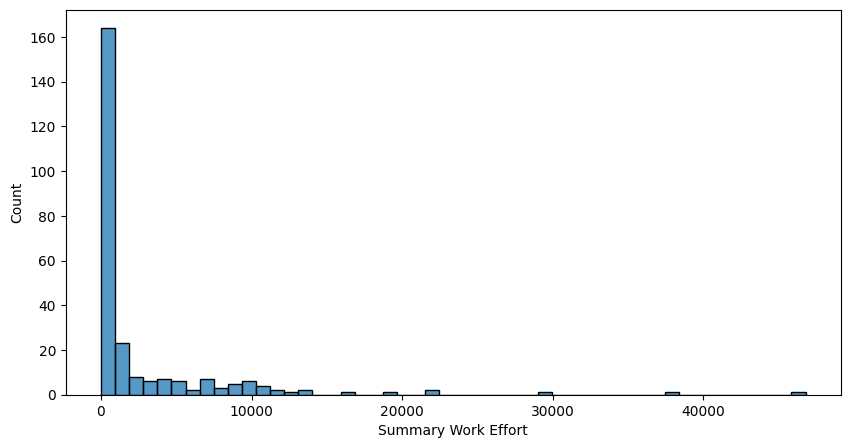

In [2]:
# Importing ISBG as dataframe
ISBG = pd.read_excel("./data/ISBSG-whole.xlsx",header=3)
# ISBG.set_index("Project ID", inplace=True)

cols_needed = ['Max Team Size','COSMIC Read','COSMIC Write','COSMIC Entry','COSMIC Exit','Project Elapsed Time','Development Platform','Primary Programming Language','Summary Work Effort']
ISBG_interest = ISBG[cols_needed]
ISBG_interest.head()

df_clean = ISBG_interest.dropna(subset=["COSMIC Read", "COSMIC Write", "COSMIC Exit", "COSMIC Entry"])
print(len(df_clean))
plt.figure(figsize=(10,5))
sns.histplot(df_clean['Summary Work Effort'], kde=False, bins=50)  # Set bins and kde to False

df_clean = df_clean.dropna(subset=['Summary Work Effort'])


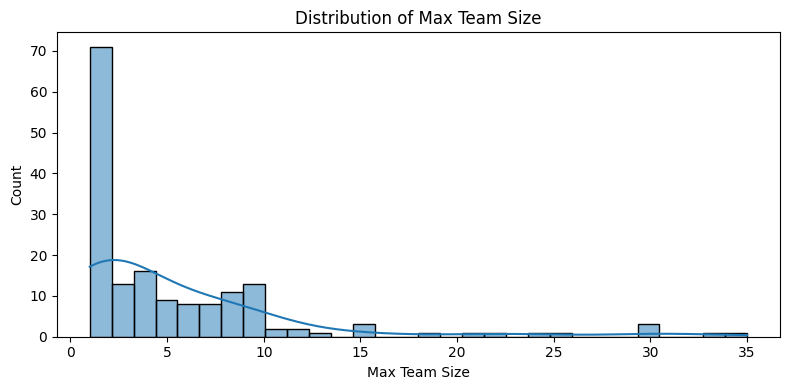

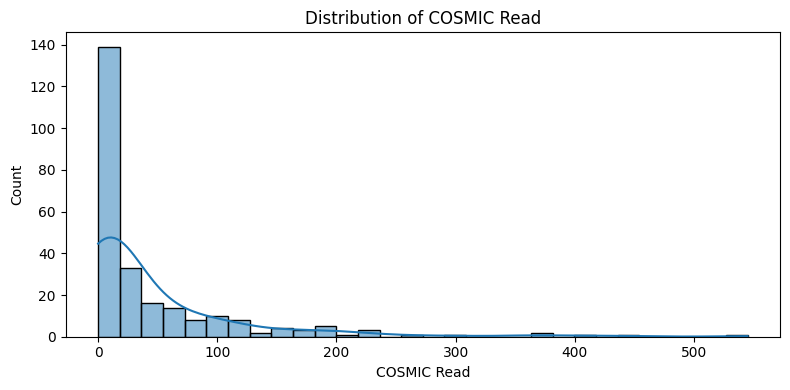

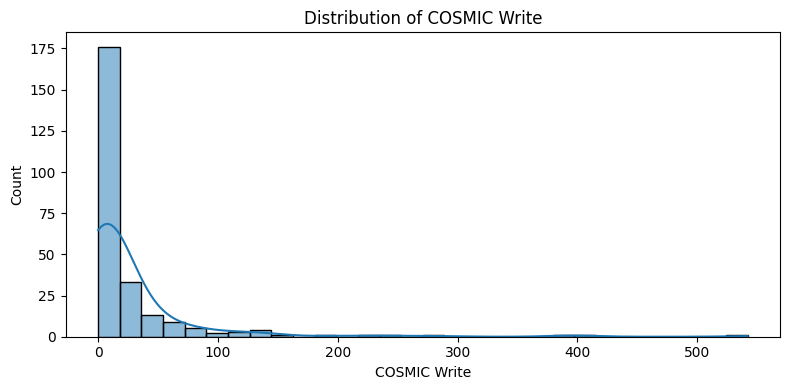

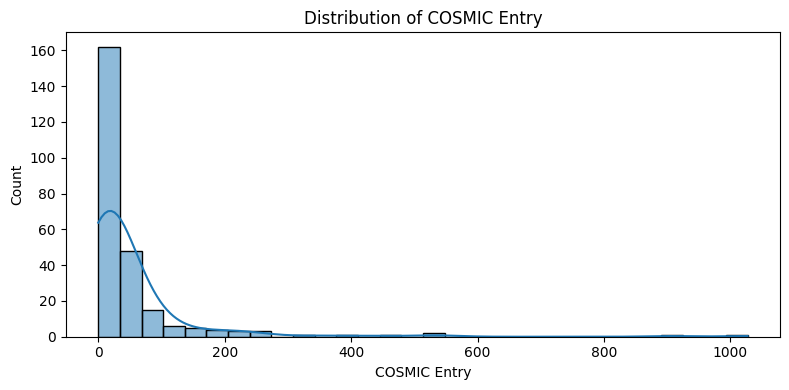

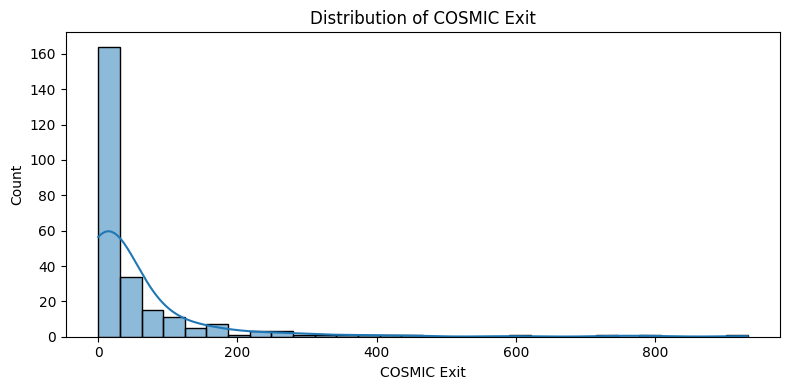

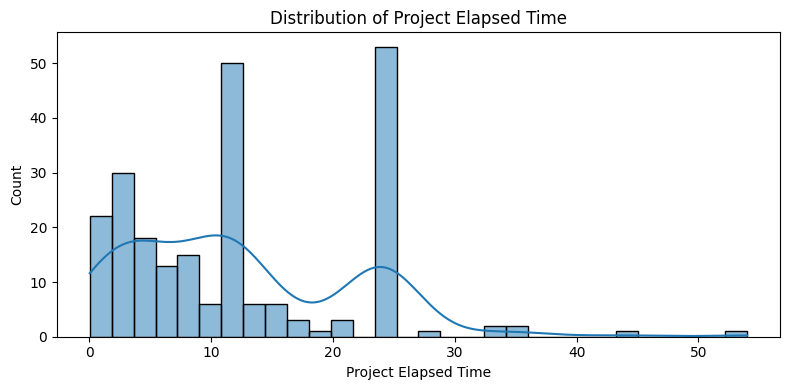

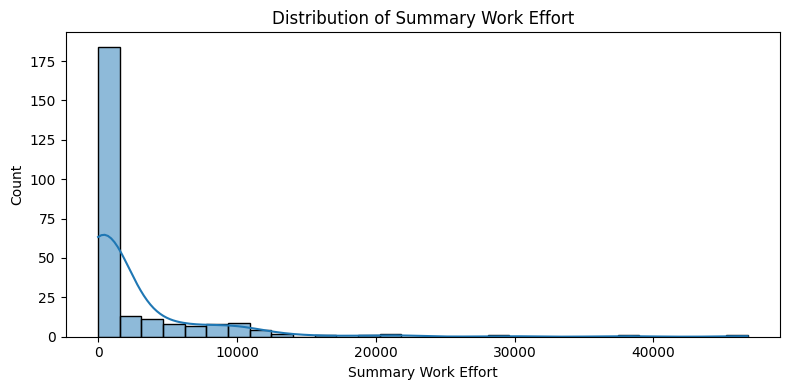

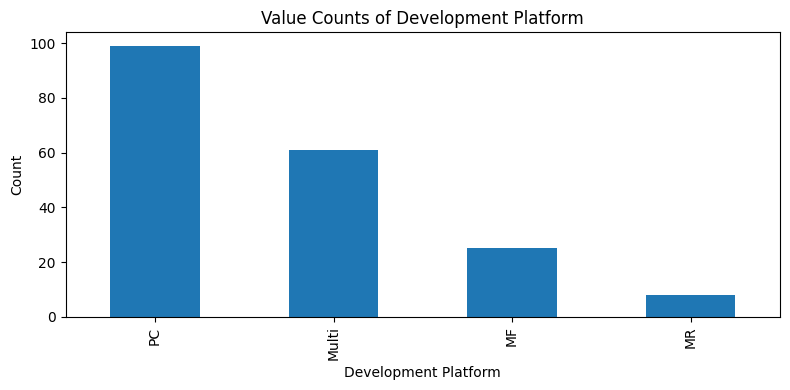

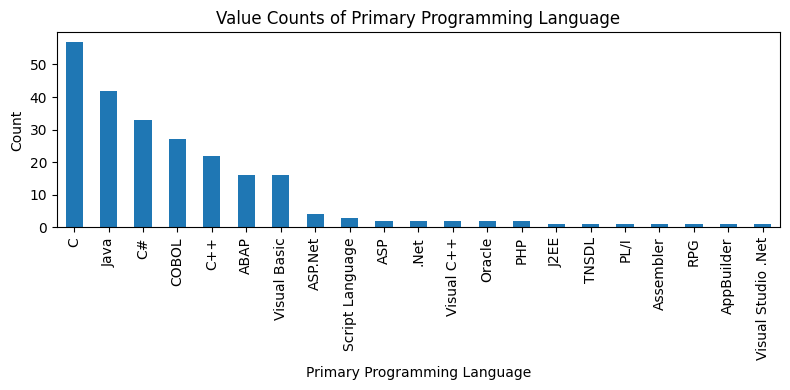

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = df_clean.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df_clean.select_dtypes(include=['object']).columns

for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df_clean[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    df_clean[col].value_counts().plot(kind='bar')
    plt.title(f'Value Counts of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()


Most of them are very skewed ==> First log transforrm, then scale  
I will not log transform PET at first, as it is not skewed. I will only scale it  

One hot-encode categorical  
For PPL, gorup everything from ASP.Net into other

In [4]:
from sklearn.model_selection import train_test_split

X_clean = df_clean.drop(columns=["Summary Work Effort"])
y_clean = df_clean["Summary Work Effort"]
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42
)

from scipy.stats import ks_2samp

stat, p = ks_2samp(y_train, y_test)
print(f'KS statistic: {stat:.4f}, p-value: {p:.4f}')


KS statistic: 0.1296, p-value: 0.4582


p-value not < than .05, not a significant difference between the distribution of the train and test

In [5]:
# Median imputation for numerical columns
for col in X_train.select_dtypes(include=['float64', 'int64']).columns:
    median_value = X_train[col].median()
    X_train[col] = X_train[col].fillna(median_value)
    X_test[col] = X_test[col].fillna(median_value)

# Mode imputation for categorical columns
for col in X_train.select_dtypes(include=['object']).columns:
    mode_value = X_train[col].mode()[0]
    X_train[col] = X_train[col].fillna(mode_value)
    X_test[col] = X_test[col].fillna(mode_value)

# Log transformation for skewed numerical columns
skewed = ["COSMIC Read", "COSMIC Write", "COSMIC Entry", "COSMIC Exit", "Max Team Size"]
for col in skewed:
    X_train[col] = np.log1p(X_train[col])
    X_test[col] = np.log1p(X_test[col])

# Log transform output variable
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

# Min-max scaling for numerical columns
from sklearn.preprocessing import MinMaxScaler
numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
scaler = MinMaxScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# Threshold: keep only the top N most frequent languages
top_langs = X_train['Primary Programming Language'].value_counts().nlargest(5).index

# Replace rare languages with 'Other' in both train and test
X_train['Primary Programming Language'] = X_train['Primary Programming Language'].apply(
    lambda x: x if x in top_langs else 'Other'
)
X_test['Primary Programming Language'] = X_test['Primary Programming Language'].apply(
    lambda x: x if x in top_langs else 'Other'
)

# One-hot encoding for categorical columns
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# Align test set to train set
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

#Split into functioal and technical features
X_func_train = X_train[["COSMIC Read", "COSMIC Write", "COSMIC Entry", "COSMIC Exit"]]
X_tech_train = X_train.drop(columns=["COSMIC Read", "COSMIC Write", "COSMIC Entry", "COSMIC Exit"])
X_func_test = X_test[["COSMIC Read", "COSMIC Write", "COSMIC Entry", "COSMIC Exit"]]
X_tech_test = X_test.drop(columns=["COSMIC Read", "COSMIC Write", "COSMIC Entry", "COSMIC Exit"])

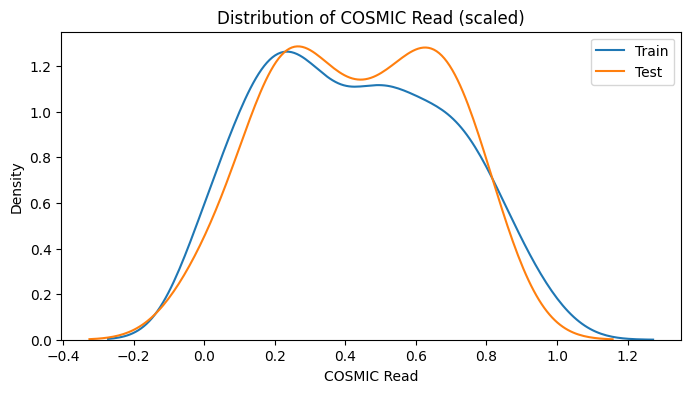

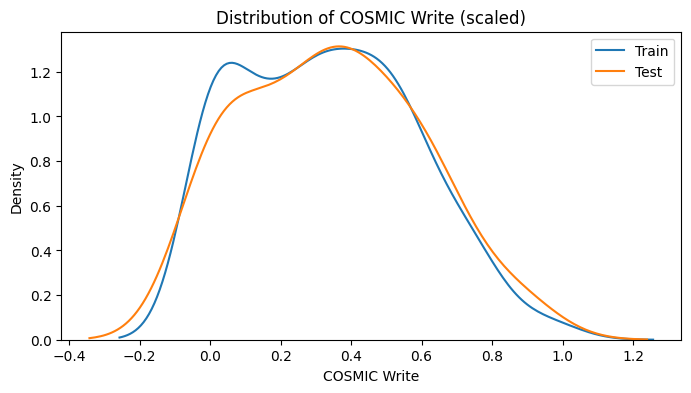

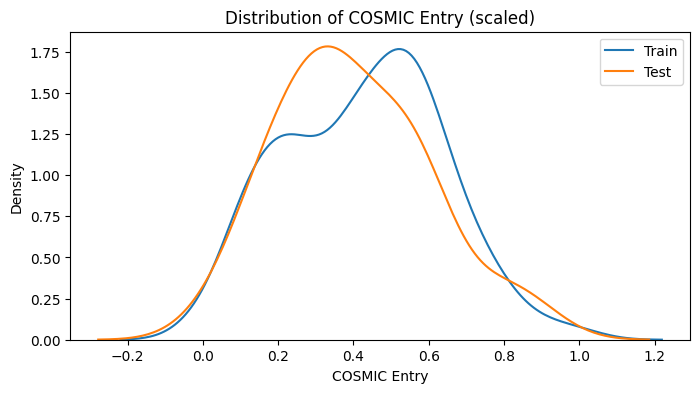

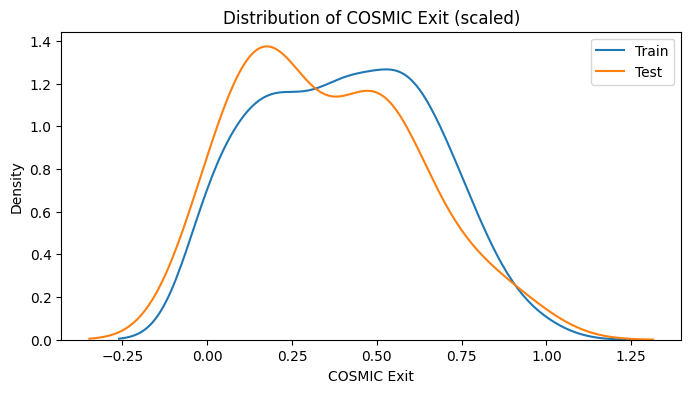

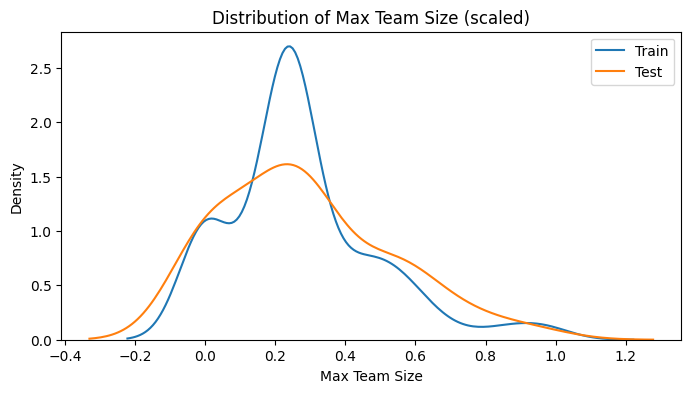

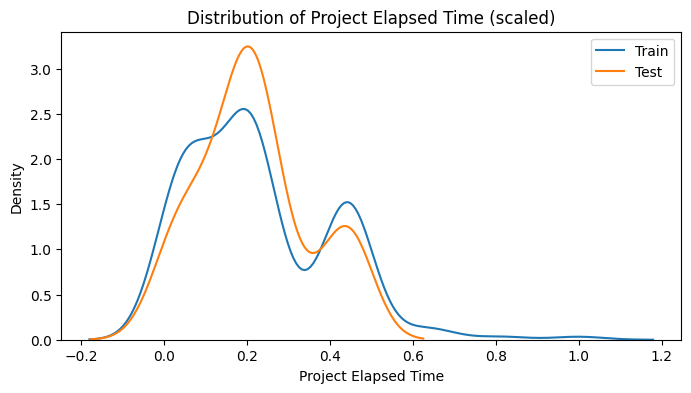

In [6]:
import matplotlib.pyplot as plt

def compare_feature_distribution(feature_name):
    plt.figure(figsize=(8, 4))
    sns.kdeplot(X_train[feature_name], label='Train')
    sns.kdeplot(X_test[feature_name], label='Test')
    plt.title(f'Distribution of {feature_name} (scaled)')
    plt.legend()
    plt.show()

compare_feature_distribution('COSMIC Read')
compare_feature_distribution('COSMIC Write')
compare_feature_distribution('COSMIC Entry')
compare_feature_distribution('COSMIC Exit')
compare_feature_distribution('Max Team Size')
compare_feature_distribution('Project Elapsed Time')

In [7]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
import numpy as np

# Define model
dt = DecisionTreeRegressor(random_state=42)
"""""
# Define scoring metrics (on log scale)
scoring = {
    'r2': 'r2',
    'mae': make_scorer(mean_absolute_error),
    'mse': make_scorer(mean_squared_error),
}

# Run 5-fold cross-validation
cv_results = cross_validate(
    dt,
    X_train,
    y_train,  # log-transformed SWE
    cv=10,
    scoring=scoring,
    return_train_score=False
)

# Show average scores
for metric in scoring:
    scores = cv_results[f'test_{metric}']
    print(f"{metric.upper()} (mean ± std): {scores.mean():.4f} ± {scores.std():.4f}")

"""

def evaluate_model(X, y, model=None, label=""):
    if model is None:
        model = DecisionTreeRegressor(random_state=42)

    scoring = {
        'r2': 'r2',
        'mae': make_scorer(mean_absolute_error),
        'mse': make_scorer(mean_squared_error),
    }

    results = cross_validate(model, X, y, cv=10, scoring=scoring, return_train_score=False)

    print(f"\n--- {label} ---")
    for metric in scoring:
        scores = results[f'test_{metric}']
        print(f"{metric.upper()} (mean ± std): {scores.mean():.4f} ± {scores.std():.4f}")


# Functional features only
evaluate_model(X_func_train, y_train, label="Functional Approach")

# Technical features (with dummy-coded categoricals)
evaluate_model(X_tech_train, y_train, label="Technical Approach")

# Both
evaluate_model(X_train, y_train, label="Both")


--- Functional Approach ---
R2 (mean ± std): 0.1972 ± 0.2555
MAE (mean ± std): 1.3450 ± 0.1467
MSE (mean ± std): 3.0674 ± 0.5853

--- Technical Approach ---
R2 (mean ± std): 0.6136 ± 0.1114
MAE (mean ± std): 0.8973 ± 0.1895
MSE (mean ± std): 1.5838 ± 0.6205

--- Both ---
R2 (mean ± std): 0.6351 ± 0.1038
MAE (mean ± std): 0.9026 ± 0.1369
MSE (mean ± std): 1.4132 ± 0.3140


In [8]:
from sklearn.neural_network import MLPRegressor
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress only the convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Define the MLPRegressor model (you can adjust the hyperparameters as needed)
mlp = MLPRegressor(hidden_layer_sizes=(50, 50), activation='tanh', solver='adam', max_iter=1000, random_state=42, early_stopping=False)

# Functional features only
evaluate_model(X_func_train, y_train, model=mlp, label="Functional Approach (MLP)")

# Technical features only
evaluate_model(X_tech_train, y_train, model=mlp, label="Technical Approach (MLP)")

# Technical features only
evaluate_model(X_train, y_train, model=mlp, label="Both MLP")


--- Functional Approach (MLP) ---
R2 (mean ± std): 0.5639 ± 0.1334
MAE (mean ± std): 1.0542 ± 0.1623
MSE (mean ± std): 1.7336 ± 0.5573

--- Technical Approach (MLP) ---
R2 (mean ± std): 0.6851 ± 0.0998
MAE (mean ± std): 0.8297 ± 0.1532
MSE (mean ± std): 1.2729 ± 0.4816

--- Both MLP ---
R2 (mean ± std): 0.8061 ± 0.0754
MAE (mean ± std): 0.6477 ± 0.1160
MSE (mean ± std): 0.7685 ± 0.3116


In [9]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define the XGBoost model
xg_reg = xgb.XGBRegressor(
    objective='reg:squarederror', 
    colsample_bytree=0.3, 
    learning_rate=0.6,
    max_depth=10, 
    alpha=10, 
    n_estimators=100, 
    verbosity=0, 
    random_state=42
)

# Evaluate functional approach with XGBoost
evaluate_model(X_func_train, y_train, model=xg_reg, label="Functional Approach (XGBoost)")

# Evaluate technical approach with XGBoost
evaluate_model(X_tech_train, y_train, model=xg_reg, label="Technical Approach (XGBoost)")

# Evaluate technical approach with XGBoost
evaluate_model(X_train, y_train, model=xg_reg, label="Both (XGBoost)")

# Evaluate technical approach without Project Elapsed Time using XGBoost
evaluate_model(
    X_tech_train.drop(columns=['Project Elapsed Time']), 
    y_train, 
    model=xgb.XGBRegressor(
        objective='reg:squarederror',
        colsample_bytree=0.3,
        learning_rate=0.3,
        max_depth=10,
        alpha=10,
        n_estimators=100,
        verbosity=0,
        random_state=42
    ),
    label="Technical Approach w/o Project Elapsed Time (XGBoost)"
)



--- Functional Approach (XGBoost) ---
R2 (mean ± std): 0.5825 ± 0.1204
MAE (mean ± std): 1.0100 ± 0.1415
MSE (mean ± std): 1.6513 ± 0.5051

--- Technical Approach (XGBoost) ---
R2 (mean ± std): 0.6679 ± 0.0942
MAE (mean ± std): 0.8393 ± 0.1599
MSE (mean ± std): 1.3311 ± 0.4410

--- Both (XGBoost) ---
R2 (mean ± std): 0.7362 ± 0.0553
MAE (mean ± std): 0.8035 ± 0.0693
MSE (mean ± std): 1.0352 ± 0.1774

--- Technical Approach w/o Project Elapsed Time (XGBoost) ---
R2 (mean ± std): 0.6203 ± 0.1140
MAE (mean ± std): 0.9168 ± 0.1750
MSE (mean ± std): 1.5497 ± 0.5911


c:\Users\maria\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



--- Functional Approach ---
R2 (mean ± std): 0.1972 ± 0.2555
MAE (mean ± std): 1.3450 ± 0.1467
MSE (mean ± std): 3.0674 ± 0.5853


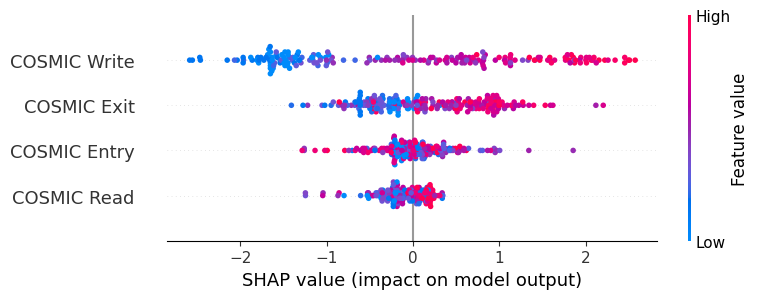


--- Technical Approach ---
R2 (mean ± std): 0.6136 ± 0.1114
MAE (mean ± std): 0.8973 ± 0.1895
MSE (mean ± std): 1.5838 ± 0.6205


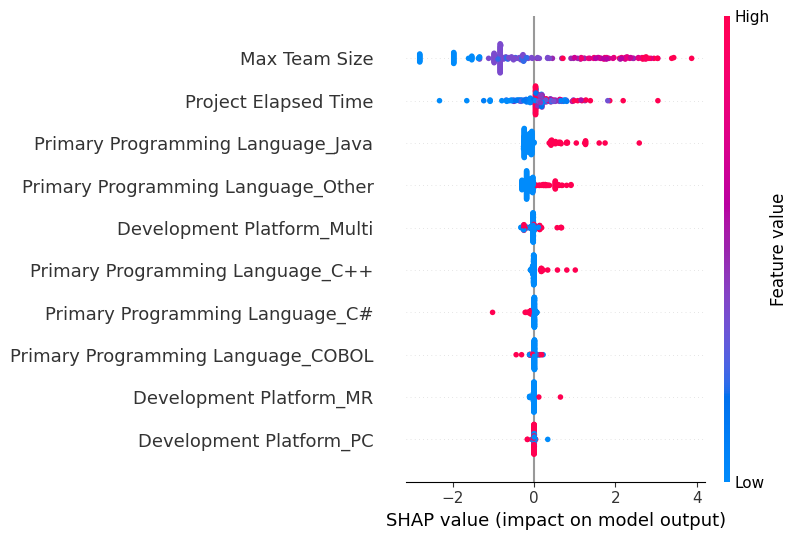

In [10]:
import shap

# Define model
dt = DecisionTreeRegressor(random_state=42)

def evaluate_model(X, y, model=None, label=""):
    if model is None:
        model = DecisionTreeRegressor(random_state=42)
    
    scoring = {
        'r2': 'r2',
        'mae': make_scorer(mean_absolute_error),
        'mse': make_scorer(mean_squared_error),
    }

    # Run cross-validation and collect results
    results = cross_validate(model, X, y, cv=10, scoring=scoring, return_train_score=False)

    print(f"\n--- {label} ---")
    
    # Print the cross-validation scores
    for metric in scoring:
        scores = results[f'test_{metric}']
        print(f"{metric.upper()} (mean ± std): {scores.mean():.4f} ± {scores.std():.4f}")
    
    # Fit the model on the full training data to compute SHAP values
    model.fit(X, y)
    
    # Use SHAP to explain the model's predictions
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)

    # Plot feature importance using SHAP summary plot
    shap.summary_plot(shap_values, X)

# Functional features only
evaluate_model(X_func_train, y_train, label="Functional Approach")

# Technical features (with dummy-coded categoricals)
evaluate_model(X_tech_train, y_train, label="Technical Approach")
